ECG data shape: (987, 5000, 1)
Epoch [1/20], Loss D: 11.2553, Loss G: 0.6142


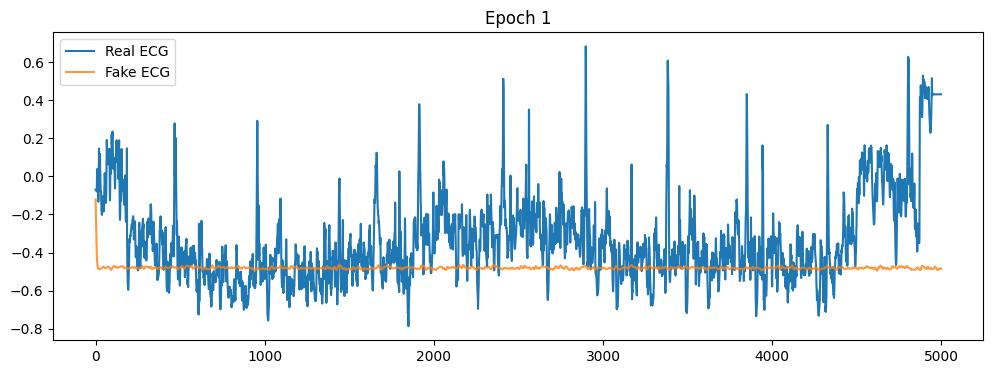

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
# 1. Data Loading and Preprocessing
# ------------------------------
def load_and_preprocess_ecg_data(csv_path="C:/Users/M2-Winterfell/Downloads/Dissertation/TimeGAN/data/lead_I_data.csv"):
    """
    Loads and preprocesses ECG data from CSV, skipping the header row.
    """
    df = pd.read_csv(csv_path, header=None, skiprows=1)
    data = df.values  # Expected shape: (987, 5000)
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Reshape to [samples, timesteps, features]
    data_scaled = data_scaled.reshape(data_scaled.shape[0], data_scaled.shape[1], 1)
    
    return data_scaled, scaler

# Load the ECG data
ecg_data_np, ecg_scaler = load_and_preprocess_ecg_data()
print("ECG data shape:", ecg_data_np.shape)  # Expected: (987, 5000, 1)

# Convert to torch.Tensor
ecg_data_tensor = torch.tensor(ecg_data_np, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = TensorDataset(ecg_data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ------------------------------
# 2. Define the Networks (Generator, Recovery, Discriminator)
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator: maps noise (z) to a latent representation
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dim, num_layers, seq_len):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size=z_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        
    def forward(self, z):
        out, _ = self.gru(z)  # (batch_size, seq_len, hidden_dim)
        out = self.fc(out)
        out = self.tanh(out)
        return out

# Recovery: maps the latent representation to ECG data
class Recovery(nn.Module):
    def __init__(self, hidden_dim, num_layers, seq_len, output_dim=1):
        super(Recovery, self).__init__()
        self.gru = nn.GRU(input_size=hidden_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()  # Assumes data scaled to [-1,1]
        
    def forward(self, h):
        out, _ = self.gru(h)  # (batch_size, seq_len, hidden_dim)
        out = self.fc(out)    # (batch_size, seq_len, output_dim)
        out = self.tanh(out)
        return out

# Discriminator: distinguishes real ECG from fake ECG
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=24, num_layers=3, seq_len=5000):
        super(Discriminator, self).__init__()
        self.gru = nn.GRU(input_size=input_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.gru(x)  # (batch_size, seq_len, hidden_dim)
        last_out = out[:, -1, :]  # Use the last time step as summary
        out = self.fc(last_out)
        out = self.sigmoid(out)
        return out

# Hyperparameters for networks
seq_len = 5000
z_dim = 24
hidden_dim = 24
num_layers = 3

# Instantiate networks and move to device
G = Generator(z_dim=z_dim, hidden_dim=hidden_dim, num_layers=num_layers, seq_len=seq_len).to(device)
R = Recovery(hidden_dim=hidden_dim, num_layers=num_layers, seq_len=seq_len, output_dim=1).to(device)
D = Discriminator(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, seq_len=seq_len).to(device)

# ------------------------------
# 3. Define Optimizers and Loss Function
# ------------------------------
lr = 0.0002
optimizer_G = optim.Adam(list(G.parameters()) + list(R.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Function to compute gradient penalty
def compute_gradient_penalty(D, real_data, fake_data, device, lambda_gp=10):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1, device=device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return lambda_gp * gradient_penalty

# ------------------------------
# 4. Full Training Loop (20 epochs, plotting every epoch)
# ------------------------------
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    for batch in data_loader:
        real_ecg = batch[0].to(device)  # Shape: (batch_size, seq_len, 1)
        current_bs = real_ecg.size(0)
        
        # --- Create smoothed labels ---
        real_labels = torch.full((current_bs, 1), 0.9, device=device)  # Use 0.9 for real
        fake_labels = torch.full((current_bs, 1), 0.1, device=device)  # Use 0.1 for fake
        
        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        
        # Discriminator loss on real data
        outputs_real = D(real_ecg)
        loss_D_real = criterion(outputs_real, real_labels)
        
        # Generate fake ECG:
        noise = torch.randn(current_bs, seq_len, z_dim).to(device)
        fake_latent = G(noise)
        fake_ecg = R(fake_latent)
        
        outputs_fake = D(fake_ecg.detach())  # Detach so gradients don't flow to G & R
        loss_D_fake = criterion(outputs_fake, fake_labels)
        
        # Compute gradient penalty
        gp = compute_gradient_penalty(D, real_ecg, fake_ecg.detach(), device)
        
        loss_D = loss_D_real + loss_D_fake + gp
        loss_D.backward()
        optimizer_D.step()
        
        # --- Train Generator + Recovery (Combined Generator) ---
        optimizer_G.zero_grad()
        
        noise = torch.randn(current_bs, seq_len, z_dim).to(device)
        fake_latent = G(noise)
        fake_ecg = R(fake_latent)
        
        outputs = D(fake_ecg)
        loss_G_adv = criterion(outputs, real_labels)  # Adversarial loss (try to fool D)
        
        # --- (Optional) Add Reconstruction/Supervised Loss ---
        # In TimeGAN, an additional loss (e.g., reconstruction loss) is used to preserve temporal dynamics.
        # For example, if you had an encoder E, you could compute:
        # reconstructed = R(E(real_ecg))
        # loss_recon = nn.MSELoss()(reconstructed, real_ecg)
        # Then combine losses: loss_G = loss_G_adv + lambda_recon * loss_recon
        # Here we only use adversarial loss for simplicity.
        
        loss_G = loss_G_adv
        loss_G.backward()
        optimizer_G.step()
    
    print(f"Epoch [{epoch}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
    
    # Plot one real and one fake ECG sample every epoch
    with torch.no_grad():
        real_sample = real_ecg[0].cpu().numpy().squeeze()
        noise = torch.randn(1, seq_len, z_dim).to(device)
        fake_sample = R(G(noise)).cpu().numpy().squeeze()
            
    plt.figure(figsize=(12, 4))
    plt.plot(real_sample, label="Real ECG")
    plt.plot(fake_sample, label="Fake ECG", alpha=0.8)
    plt.title(f"Epoch {epoch}")
    plt.legend()
    plt.show()
